1. Vanilla Autoencoder  
2. Multilayer Autoencoder  
3. Convolutional Autoencoder  
4. Regularized Autoencoder (Sparse + Denoising)

## Importing the Libraries

We're using TensorFlow/Keras here since it gives us a clean, readable way to define and train models. NumPy handles array math and Matplotlib takes care of all the visualizations.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Conv2D, MaxPooling2D,
                                     UpSampling2D)
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical

# Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

## Loading & Preparing the Data

MNIST is a classic benchmark — 70,000 grayscale images of handwritten digits (0–9), each 28×28 pixels. Autoencoders are **unsupervised**, so we don't actually need the class labels. The network learns purely from pixel values.

We create two versions of the dataset upfront:
- **Flat** (784-dim vectors) — for the Dense-based models
- **2D** (28×28×1 tensors) — for the Conv-based models

In [ ]:
# Load raw data
(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = mnist.load_data()

# ── 2D version (for Conv models) ──────────────────────────────────────────────
X_train_2d = X_train_raw.reshape(-1, 28, 28, 1).astype("float32") / 255.
X_test_2d  = X_test_raw.reshape(-1, 28, 28, 1).astype("float32") / 255.

# ── Flat version (for Dense models) ──────────────────────────────────────────
X_train_flat = X_train_2d.reshape(len(X_train_2d), -1)
X_test_flat  = X_test_2d.reshape(len(X_test_2d),  -1)

print(f"2D  — train: {X_train_2d.shape}  |  test: {X_test_2d.shape}")
print(f"Flat — train: {X_train_flat.shape}  |  test: {X_test_flat.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
2D  — train: (60000, 28, 28, 1)  |  test: (10000, 28, 28, 1)
Flat — train: (60000, 784)  |  test: (10000, 784)


In [ ]:
# ── Reusable plotting helper ──────────────────────────────────────────────────
def plot_reconstructions(originals, reconstructions, title="", n=10, figsize=(20, 4)):
    """Display original vs reconstructed images side-by-side."""
    plt.figure(figsize=figsize)
    plt.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(originals[i].reshape(28, 28), cmap='gray', interpolation='nearest')
        ax.set_axis_off()
        if i == n // 2:
            ax.set_title("Originals", fontsize=10)
        # Reconstruction
        ax = plt.subplot(2, n, i + n + 1)
        plt.imshow(reconstructions[i].reshape(28, 28), cmap='gray', interpolation='nearest')
        ax.set_axis_off()
        if i == n // 2:
            ax.set_title("Reconstructed", fontsize=10)
    plt.tight_layout()
    plt.show()

def plot_loss(history, title="Training Loss"):
    """Plot train vs validation loss."""
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'],     label='Train',      linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation', linewidth=2, linestyle='--')
    plt.title(title, fontsize=13, fontweight='bold')
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.legend(); plt.grid(alpha=0.3)
    plt.tight_layout(); plt.show()

print("Helper functions defined.")

Helper functions defined.


---

# **1. Vanilla Autoencoder**

The simplest possible autoencoder — just three layers. An input layer, a small compressed (encoded) layer, and an output layer that tries to reconstruct the original.

The bottleneck is what makes it work. With only 64 neurons in the middle (vs 784 in the input) the network *has* to figure out the most important features. It can't just memorize — it must compress.

**Architecture:** `784 → 64 → 784`

### Building the Network

- **Encoder:** 784 → 64, ReLU  
- **Decoder:** 64 → 784, Sigmoid (outputs in [0, 1], matching normalized pixel range)  
- **Loss:** Mean Squared Error

In [ ]:
K.clear_session()

input_size  = 784
hidden_size = 64
output_size = 784

x_in  = Input(shape=(input_size,), name="input")
h     = Dense(hidden_size, activation='relu', name="bottleneck")(x_in)
x_out = Dense(output_size, activation='sigmoid', name="output")(h)

vanilla_ae = Model(inputs=x_in, outputs=x_out, name="Vanilla_AE")
vanilla_ae.compile(optimizer='adam', loss='mse')
vanilla_ae.summary()

Model: "Vanilla_AE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 784)            │        50,960 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,200 (395.31 KB)

 Trainable params: 101,200 (395.31 KB)

 Non-trainable params: 0 (0.00 B)

### Training

We pass `X_train_flat` as both the input **and** the target — that's the autoencoder trick.

In [ ]:
EPOCHS     = 15
BATCH_SIZE = 128

history_vanilla = vanilla_ae.fit(
    X_train_flat, X_train_flat,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=(X_test_flat, X_test_flat)
)

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0757 - val_loss: 0.0226
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0195 - val_loss: 0.0123
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0084
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0081 - val_loss: 0.0065
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0065 - val_loss: 0.0055
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0056 - val_loss: 0.0050
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 9/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 10/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 11/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 12/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

### Visualizing the Latent Space

We pull out the encoder half and look at what the 64-dimensional compressed representation looks like when reshaped into a 4×16 grid.

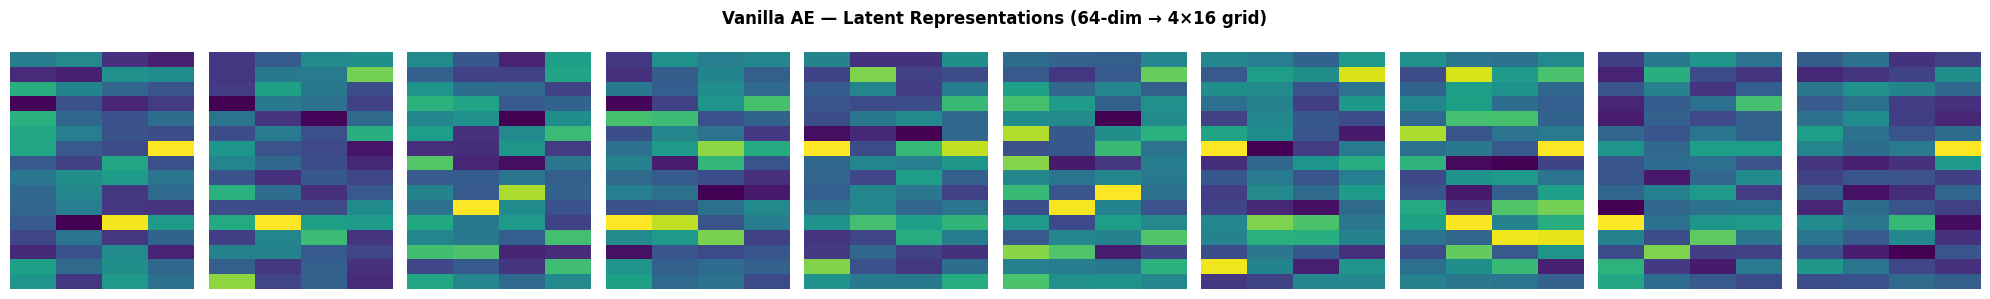

In [ ]:
encoder_vanilla = Model(x_in, h, name="Vanilla_Encoder")
encoded = encoder_vanilla.predict(X_test_flat, verbose=0)

n = 10
plt.figure(figsize=(20, 3))
plt.suptitle("Vanilla AE — Latent Representations (64-dim → 4×16 grid)", fontsize=12, fontweight='bold')
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(encoded[i].reshape(4, 16).T, cmap='viridis', aspect='auto')
    ax.set_axis_off()
plt.tight_layout()
plt.show()

### Original vs Reconstructed

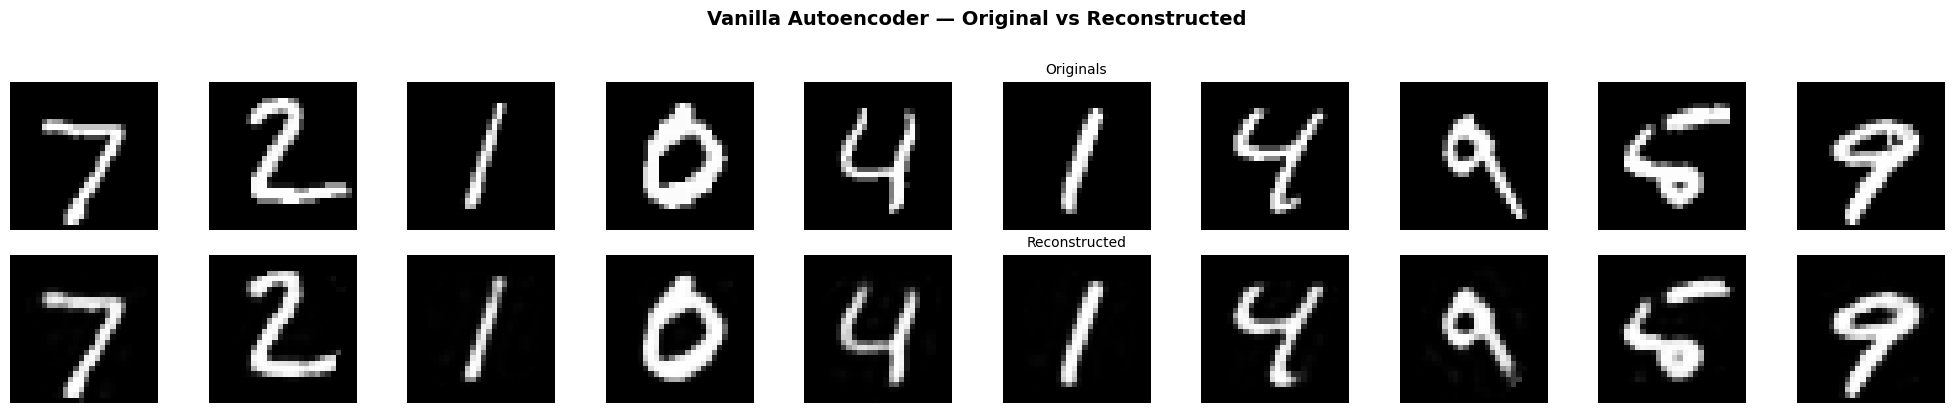

In [ ]:
decoded_vanilla = vanilla_ae.predict(X_test_flat, verbose=0)
plot_reconstructions(X_test_flat, decoded_vanilla,
                     title="Vanilla Autoencoder — Original vs Reconstructed")

### Training Loss

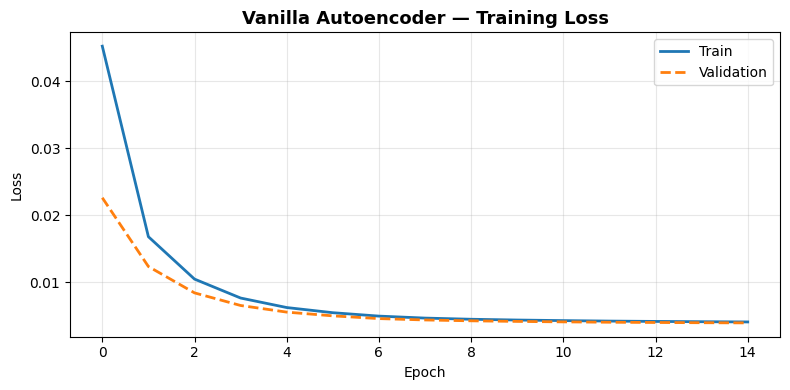

In [ ]:
plot_loss(history_vanilla, title="Vanilla Autoencoder — Training Loss")

---

# **2. Multilayer Autoencoder**

Now we go a bit deeper. Instead of jumping straight from 784 to 64, we add an intermediate hidden layer. This gives the model more capacity — it can extract richer, more hierarchical features before hitting the bottleneck.

Think of it this way: the first hidden layer picks up local patterns, the bottleneck captures the high-level structure, and the decoder mirrors the process in reverse.

**Architecture:** `784 → 128 → 64 → 128 → 784`

In [ ]:
K.clear_session()

input_size  = 784
hidden_size = 128
code_size   = 64

x_in     = Input(shape=(input_size,), name="input")
hidden_1 = Dense(hidden_size, activation='relu', name="encoder_hidden")(x_in)
bottleneck = Dense(code_size, activation='relu', name="bottleneck")(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu', name="decoder_hidden")(bottleneck)
x_out    = Dense(input_size, activation='sigmoid', name="output")(hidden_2)

multi_ae = Model(inputs=x_in, outputs=x_out, name="Multilayer_AE")
multi_ae.compile(optimizer='adam', loss='mse')
multi_ae.summary()

Model: "Multilayer_AE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_hidden (Dense)          │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_hidden (Dense)          │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 784)            │       101,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 218,192 (852.31 KB)

 Trainable params: 218,192 (852.31 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_multi = multi_ae.fit(
    X_train_flat, X_train_flat,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=(X_test_flat, X_test_flat)
)

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0715 - val_loss: 0.0201
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0182 - val_loss: 0.0129
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0127 - val_loss: 0.0106
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0106 - val_loss: 0.0092
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0093 - val_loss: 0.0083
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0085 - val_loss: 0.0076
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0078 - val_loss: 0.0071
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0073 - val_loss: 0.0067
Epoch 9/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0068 - val_loss: 0.0063
Epoch 10/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0065 - val_loss: 0.0061
Epoch 11/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0062 - val_loss: 0.0059
Epoch 12/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

### Visualizing the Latent Space

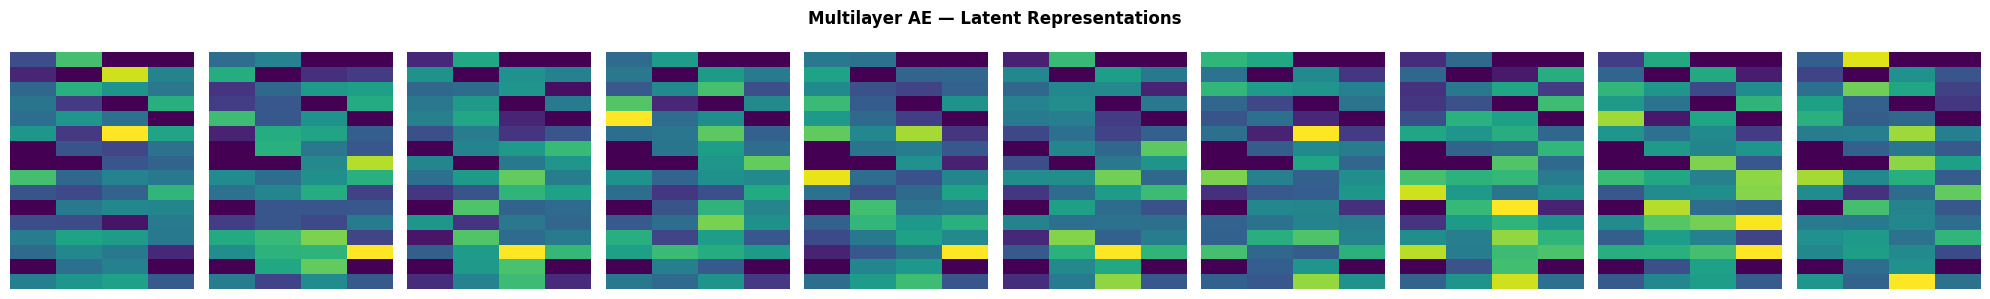

In [ ]:
encoder_multi = Model(x_in, bottleneck, name="Multi_Encoder")
encoded_multi = encoder_multi.predict(X_test_flat, verbose=0)

n = 10
plt.figure(figsize=(20, 3))
plt.suptitle("Multilayer AE — Latent Representations", fontsize=12, fontweight='bold')
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(encoded_multi[i].reshape(4, 16).T, cmap='viridis', aspect='auto')
    ax.set_axis_off()
plt.tight_layout()
plt.show()

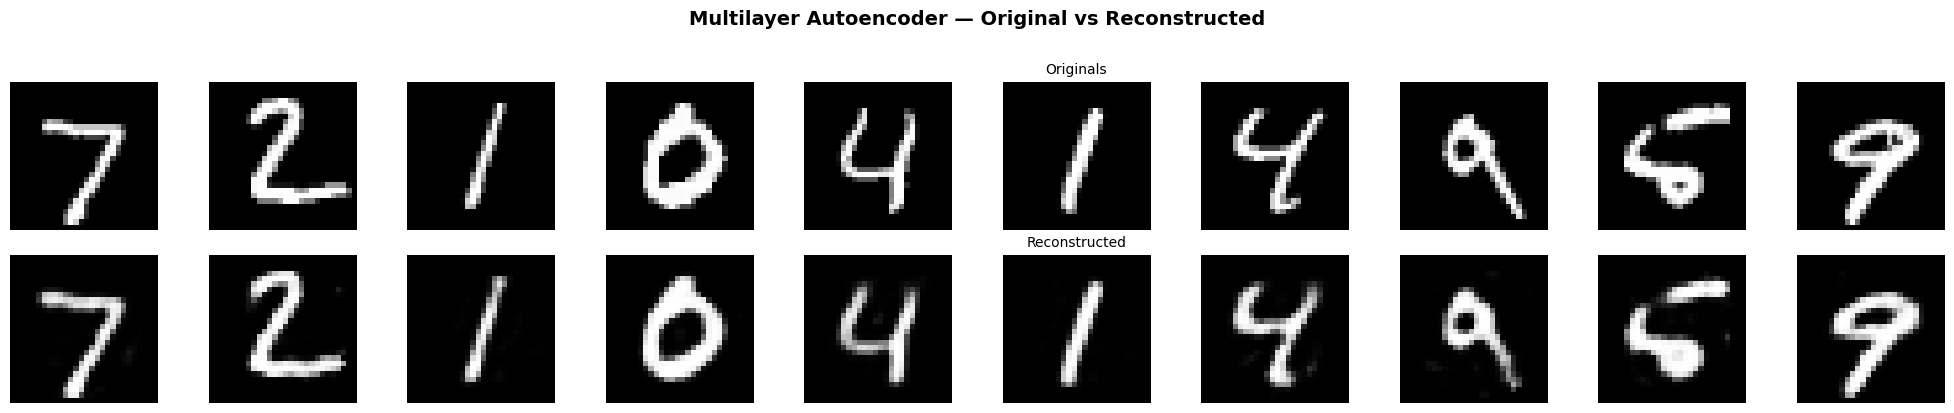

In [ ]:
decoded_multi = multi_ae.predict(X_test_flat, verbose=0)
plot_reconstructions(X_test_flat, decoded_multi,
                     title="Multilayer Autoencoder — Original vs Reconstructed")

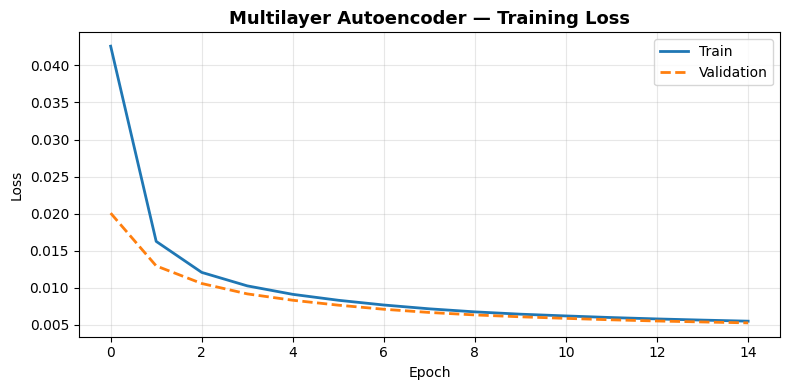

In [ ]:
plot_loss(history_multi, title="Multilayer Autoencoder — Training Loss")

---

# **3. Convolutional Autoencoder**

This is where things get more interesting. Instead of flattening images and using Dense layers, we work directly with the 2D spatial structure using convolutional layers.

Conv filters are naturally good at detecting spatial patterns — edges, curves, corners. For image data they're almost always a better fit. The encoder progressively downsamples using `MaxPooling2D`, and the decoder rebuilds using `UpSampling2D`.

**Architecture:** Conv+Pool encoder → Conv+Upsample decoder

In [ ]:
K.clear_session()

x_in = Input(shape=(28, 28, 1), name="input")

# ── Encoder ───────────────────────────────────────────────────────────────────
e1 = Conv2D(32, (3, 3), activation='relu', padding='same', name="enc_conv1")(x_in)
p1 = MaxPooling2D((2, 2), padding='same', name="enc_pool1")(e1)
e2 = Conv2D(16, (3, 3), activation='relu', padding='same', name="enc_conv2")(p1)
p2 = MaxPooling2D((2, 2), padding='same', name="enc_pool2")(e2)
e3 = Conv2D(8,  (3, 3), activation='relu', padding='same', name="enc_conv3")(p2)
encoded_conv = MaxPooling2D((2, 2), padding='same', name="bottleneck")(e3)
# Shape at bottleneck: (4, 4, 8) = 128 values

# ── Decoder ───────────────────────────────────────────────────────────────────
d1 = Conv2D(8,  (3, 3), activation='relu', padding='same', name="dec_conv1")(encoded_conv)
u1 = UpSampling2D((2, 2), name="dec_up1")(d1)
d2 = Conv2D(16, (3, 3), activation='relu', padding='same', name="dec_conv2")(u1)
u2 = UpSampling2D((2, 2), name="dec_up2")(d2)
d3 = Conv2D(32, (3, 3), activation='relu', padding='same', name="dec_conv3")(u2)
u3 = UpSampling2D((2, 2), name="dec_up3")(d3)
# After 3× upsampling: 4→8→16→32 — crop back to 28×28
x_out = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="output")(u3)
# Crop spatial dims from 32→28
from tensorflow.keras.layers import Cropping2D
x_out = Cropping2D(cropping=2, name="crop")(x_out)

conv_ae = Model(inputs=x_in, outputs=x_out, name="Conv_AE")
conv_ae.compile(optimizer='adam', loss='binary_crossentropy')
conv_ae.summary()

Model: "Conv_AE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv1 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_pool1 (MaxPooling2D)        │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv2 (Conv2D)              │ (None, 14, 14, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_pool2 (MaxPooling2D)        │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv3 (Conv2D)              │ (None, 7, 7, 8)        │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (MaxPooling2D)       │ (None, 4, 4, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv1 (Conv2D)              │ (None, 4, 4, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_up1 (UpSampling2D)          │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv2 (Conv2D)              │ (None, 8, 8, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_up2 (UpSampling2D)          │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv3 (Conv2D)              │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_up3 (UpSampling2D)          │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Conv2D)                 │ (None, 32, 32, 1)      │           289 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ crop (Cropping2D)               │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,785 (49.94 KB)

 Trainable params: 12,785 (49.94 KB)

 Non-trainable params: 0 (0.00 B)

### Training

We switch to binary cross-entropy here — it works better for pixel reconstruction in [0,1] and tends to give sharper outputs than MSE.

In [ ]:
history_conv = conv_ae.fit(
    X_train_2d, X_train_2d,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=(X_test_2d, X_test_2d)
)

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - loss: 0.2642 - val_loss: 0.1301
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1255 - val_loss: 0.1123
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1118 - val_loss: 0.1058
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1056 - val_loss: 0.1017
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1017 - val_loss: 0.0983
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0989 - val_loss: 0.0961
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0968 - val_loss: 0.0948
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0952 - val_loss: 0.0933
Epoch 9/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0939 - val_loss: 0.0921
Epoch 10/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0928 - val_loss: 0.0908
Epoch 11/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0919 - val_loss: 0.0899
Epoch 12/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/st

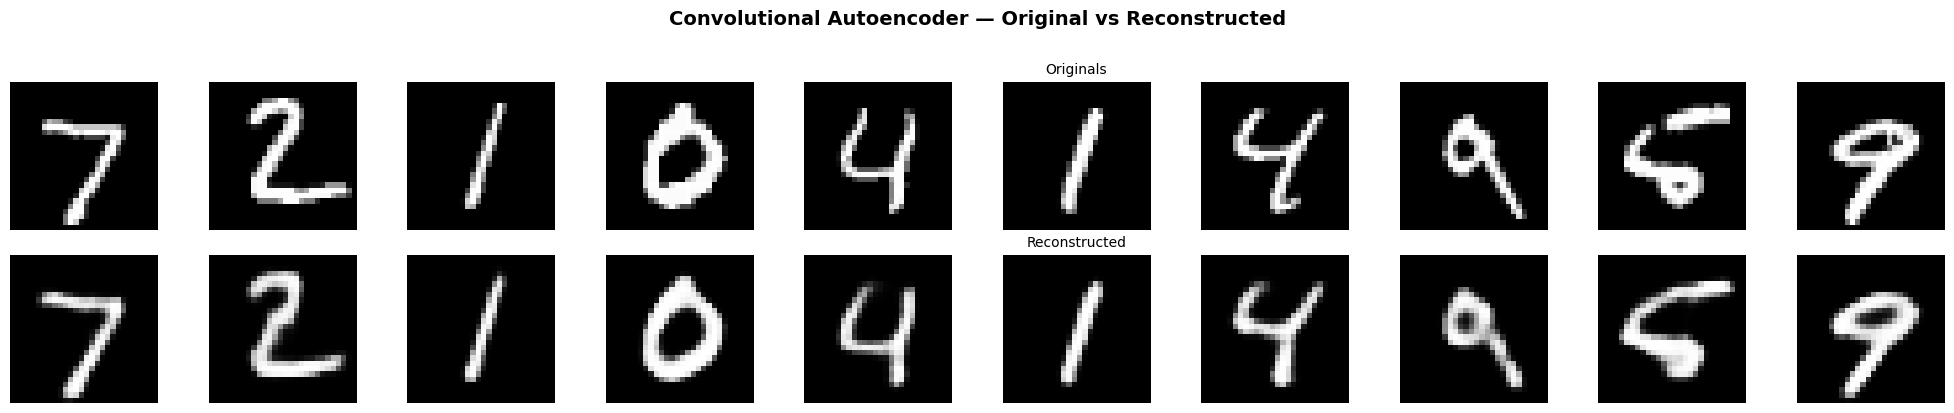

In [ ]:
decoded_conv = conv_ae.predict(X_test_2d, verbose=0)
plot_reconstructions(X_test_2d, decoded_conv,
                     title="Convolutional Autoencoder — Original vs Reconstructed")

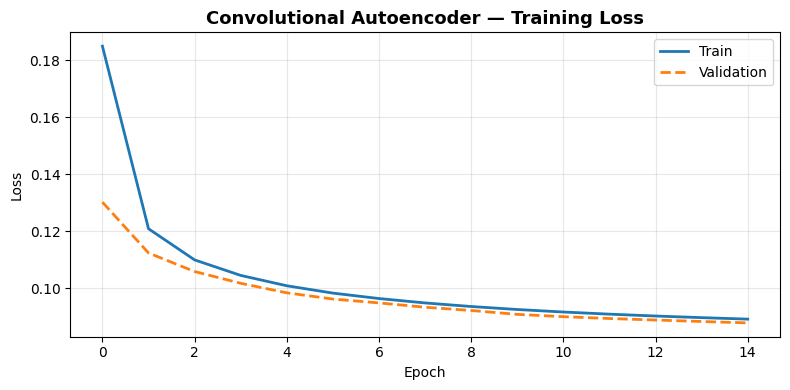

In [ ]:
plot_loss(history_conv, title="Convolutional Autoencoder — Training Loss")

---

# **4. Regularized Autoencoder**

So far nothing stopped the network from learning a near-perfect copy if the bottleneck was large enough. Regularization adds explicit constraints to encourage the model to learn *better* representations.

We look at two approaches:
- **Sparse autoencoder** — penalizes the model for activating too many neurons at once  
- **Denoising autoencoder** — corrupts the input and forces the model to recover the clean version

## Part 1: Sparse Autoencoder

The idea is simple: at any given time, only a small fraction of hidden neurons should fire. This forces each neuron to specialize — responding to specific patterns rather than activating for everything.

We enforce sparsity using **L1 activity regularization** on the hidden layer. The penalty pushes most activations toward zero.

**Architecture:** `784 → 32 (L1 sparse) → 784`

In [ ]:
K.clear_session()

input_size  = 784
hidden_size = 32
output_size = 784

x_in  = Input(shape=(input_size,), name="input")
h     = Dense(hidden_size, activation='relu',
              activity_regularizer=regularizers.l1(1e-4),
              name="sparse_bottleneck")(x_in)
x_out = Dense(output_size, activation='sigmoid', name="output")(h)

sparse_ae = Model(inputs=x_in, outputs=x_out, name="Sparse_AE")
sparse_ae.compile(optimizer='adam', loss='mse')
sparse_ae.summary()

Model: "Sparse_AE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sparse_bottleneck (Dense)       │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 784)            │        25,872 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,992 (199.19 KB)

 Trainable params: 50,992 (199.19 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_sparse = sparse_ae.fit(
    X_train_flat, X_train_flat,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=(X_test_flat, X_test_flat)
)

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.2140 - val_loss: 0.1633
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1516 - val_loss: 0.1243
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1176 - val_loss: 0.1025
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0986 - val_loss: 0.0901
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0877 - val_loss: 0.0826
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0811 - val_loss: 0.0780
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0769 - val_loss: 0.0749
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0741 - val_loss: 0.0729
Epoch 9/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0723 - val_loss: 0.0714
Epoch 10/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0710 - val_loss: 0.0704
Epoch 11/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0700 - val_loss: 0.0697
Epoch 12/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

### Sparsity Check

Let's verify the representations are actually sparse — most activations should be close to zero.

Mean activation : 0.0000
Near-zero (<0.01): 100.0% of activations


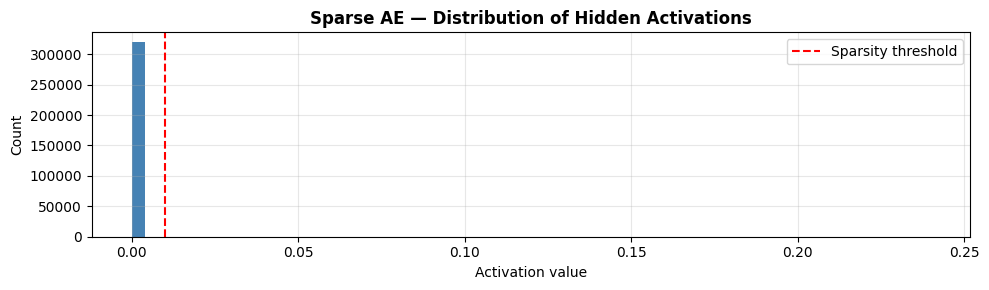

In [ ]:
encoder_sparse = Model(x_in, h, name="Sparse_Encoder")
encoded_sparse = encoder_sparse.predict(X_test_flat, verbose=0)

mean_activation = np.mean(encoded_sparse)
sparsity_pct    = np.mean(encoded_sparse < 0.01) * 100
print(f"Mean activation : {mean_activation:.4f}")
print(f"Near-zero (<0.01): {sparsity_pct:.1f}% of activations")

# Visualize activation distributions
plt.figure(figsize=(10, 3))
plt.hist(encoded_sparse.flatten(), bins=60, color='steelblue', edgecolor='none')
plt.title("Sparse AE — Distribution of Hidden Activations", fontsize=12, fontweight='bold')
plt.xlabel("Activation value"); plt.ylabel("Count")
plt.axvline(0.01, color='red', linestyle='--', label='Sparsity threshold')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

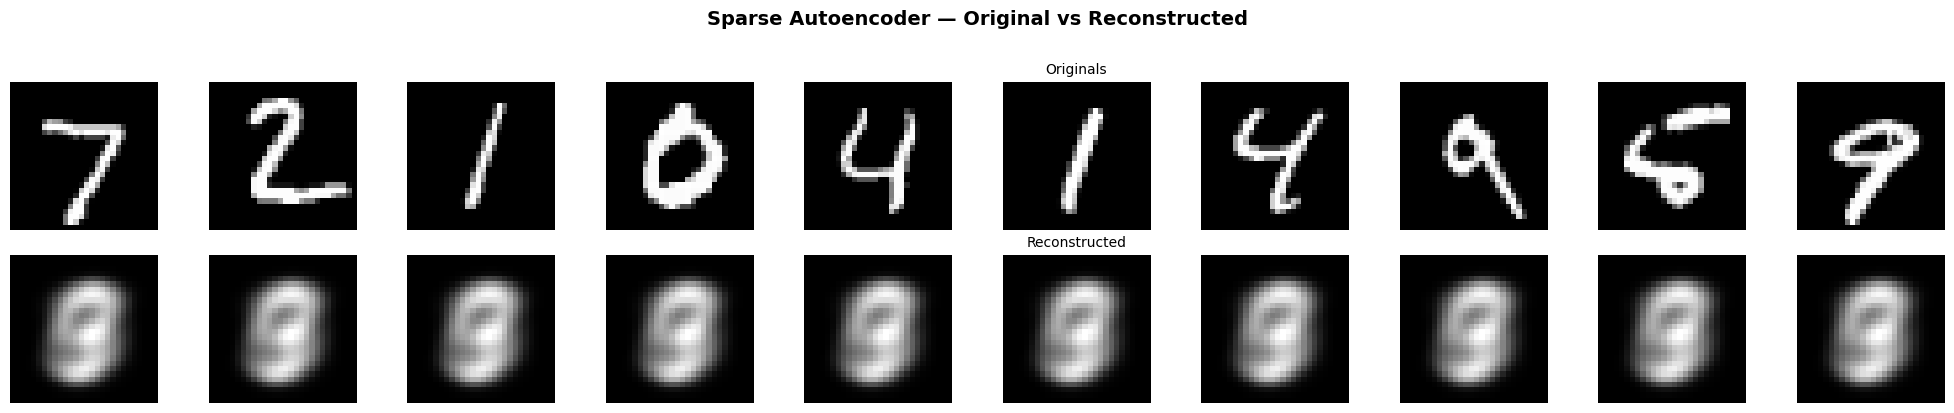

In [ ]:
decoded_sparse = sparse_ae.predict(X_test_flat, verbose=0)
plot_reconstructions(X_test_flat, decoded_sparse,
                     title="Sparse Autoencoder — Original vs Reconstructed")

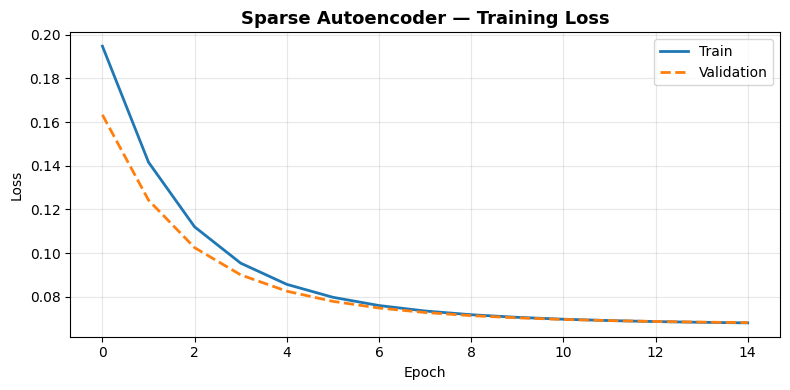

In [ ]:
plot_loss(history_sparse, title="Sparse Autoencoder — Training Loss")

## Part 2: Denoising Autoencoder

A really elegant idea. Instead of regularizing the weights, we corrupt the input and ask the network to clean it up. The model *cannot* learn a trivial identity mapping because input and target are deliberately different — noisy image goes in, clean image is expected out.

This forces the network to truly understand the underlying structure of the data, not just memorize. It also makes the model more robust in real-world scenarios where inputs are never perfectly clean.

### Adding Noise

We add Gaussian noise (factor = 0.5), then clip back to [0, 1]. The resulting images are noticeably degraded — you can still make out the digits, but there's a lot of static.

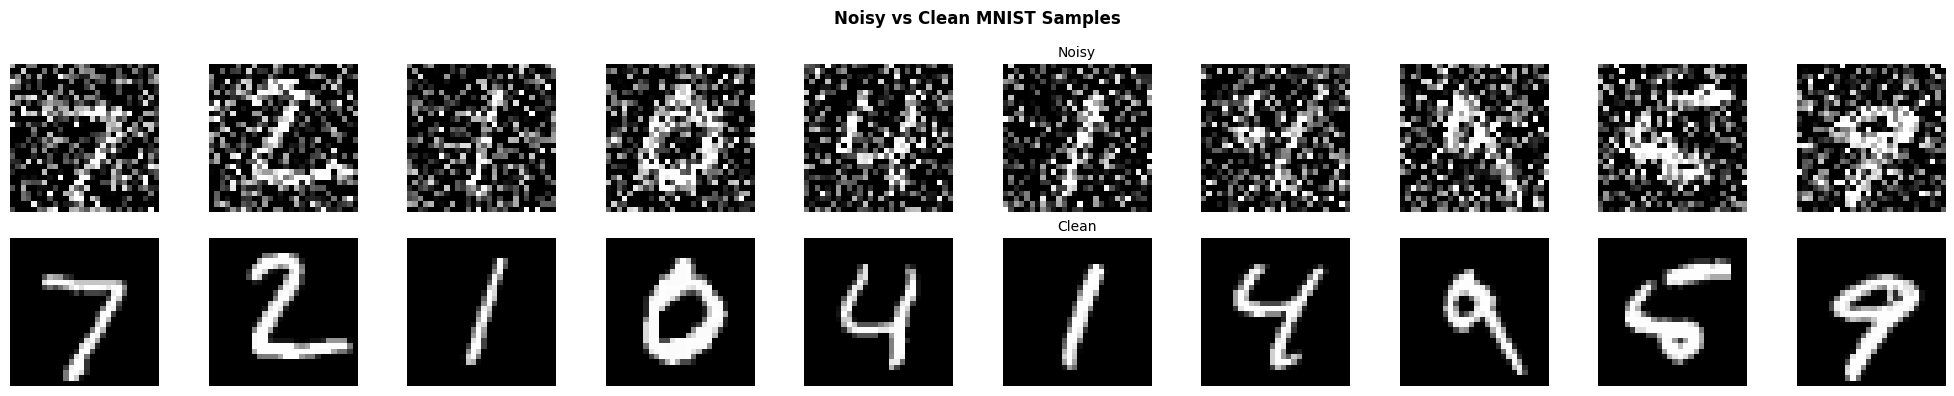

In [ ]:
noise_factor = 0.5

X_train_noisy = np.clip(
    X_train_2d + noise_factor * np.random.normal(size=X_train_2d.shape), 0., 1.)
X_test_noisy  = np.clip(
    X_test_2d  + noise_factor * np.random.normal(size=X_test_2d.shape),  0., 1.)

# Show what the noisy data looks like
n = 10
plt.figure(figsize=(20, 4))
plt.suptitle("Noisy vs Clean MNIST Samples", fontsize=12, fontweight='bold')
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test_noisy[i].reshape(28, 28), cmap='gray'); ax.set_axis_off()
    if i == n // 2: ax.set_title("Noisy", fontsize=10)
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(X_test_2d[i].reshape(28, 28), cmap='gray'); ax.set_axis_off()
    if i == n // 2: ax.set_title("Clean", fontsize=10)
plt.tight_layout(); plt.show()

### Building the Network

Convolutional architecture — better suited for spatial noise removal than Dense layers. The key difference from a standard autoencoder is the training call: **noisy in, clean out**.

In [ ]:
K.clear_session()

x_in = Input(shape=(28, 28, 1), name="input")

# ── Encoder ───────────────────────────────────────────────────────────────────
e1 = Conv2D(32, (3, 3), activation='relu', padding='same', name="enc_conv1")(x_in)
p1 = MaxPooling2D((2, 2), padding='same', name="enc_pool1")(e1)
e2 = Conv2D(32, (3, 3), activation='relu', padding='same', name="enc_conv2")(p1)
encoded_dn = MaxPooling2D((2, 2), padding='same', name="bottleneck")(e2)

# ── Decoder ───────────────────────────────────────────────────────────────────
d1 = Conv2D(32, (3, 3), activation='relu', padding='same', name="dec_conv1")(encoded_dn)
u1 = UpSampling2D((2, 2), name="dec_up1")(d1)
d2 = Conv2D(32, (3, 3), activation='relu', padding='same', name="dec_conv2")(u1)
u2 = UpSampling2D((2, 2), name="dec_up2")(d2)
x_out = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="output")(u2)

denoise_ae = Model(inputs=x_in, outputs=x_out, name="Denoising_AE")
denoise_ae.compile(optimizer='adam', loss='binary_crossentropy')
denoise_ae.summary()

Model: "Denoising_AE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv1 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_pool1 (MaxPooling2D)        │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv2 (Conv2D)              │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (MaxPooling2D)       │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv1 (Conv2D)              │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_up1 (UpSampling2D)          │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv2 (Conv2D)              │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_up2 (UpSampling2D)          │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Conv2D)                 │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

### Training

The critical line here is `fit(X_train_noisy, X_train_2d, ...)` — noisy input, clean target. That's what separates the denoising autoencoder from everything we've built so far.

In [ ]:
history_denoise = denoise_ae.fit(
    X_train_noisy, X_train_2d,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=(X_test_noisy, X_test_2d)
)

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.2674 - val_loss: 0.1160
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1152 - val_loss: 0.1088
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1092 - val_loss: 0.1050
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1056 - val_loss: 0.1026
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1034 - val_loss: 0.1010
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1019 - val_loss: 0.1001
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1008 - val_loss: 0.0989
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0998 - val_loss: 0.0982
Epoch 9/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0991 - val_loss: 0.0976
Epoch 10/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0985 - val_loss: 0.0971
Epoch 11/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0980 - val_loss: 0.0968
Epoch 12/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/st

### Results — Noisy Input vs Denoised Output

Three rows: Original → Noisy → Denoised. The difference should be pretty striking.

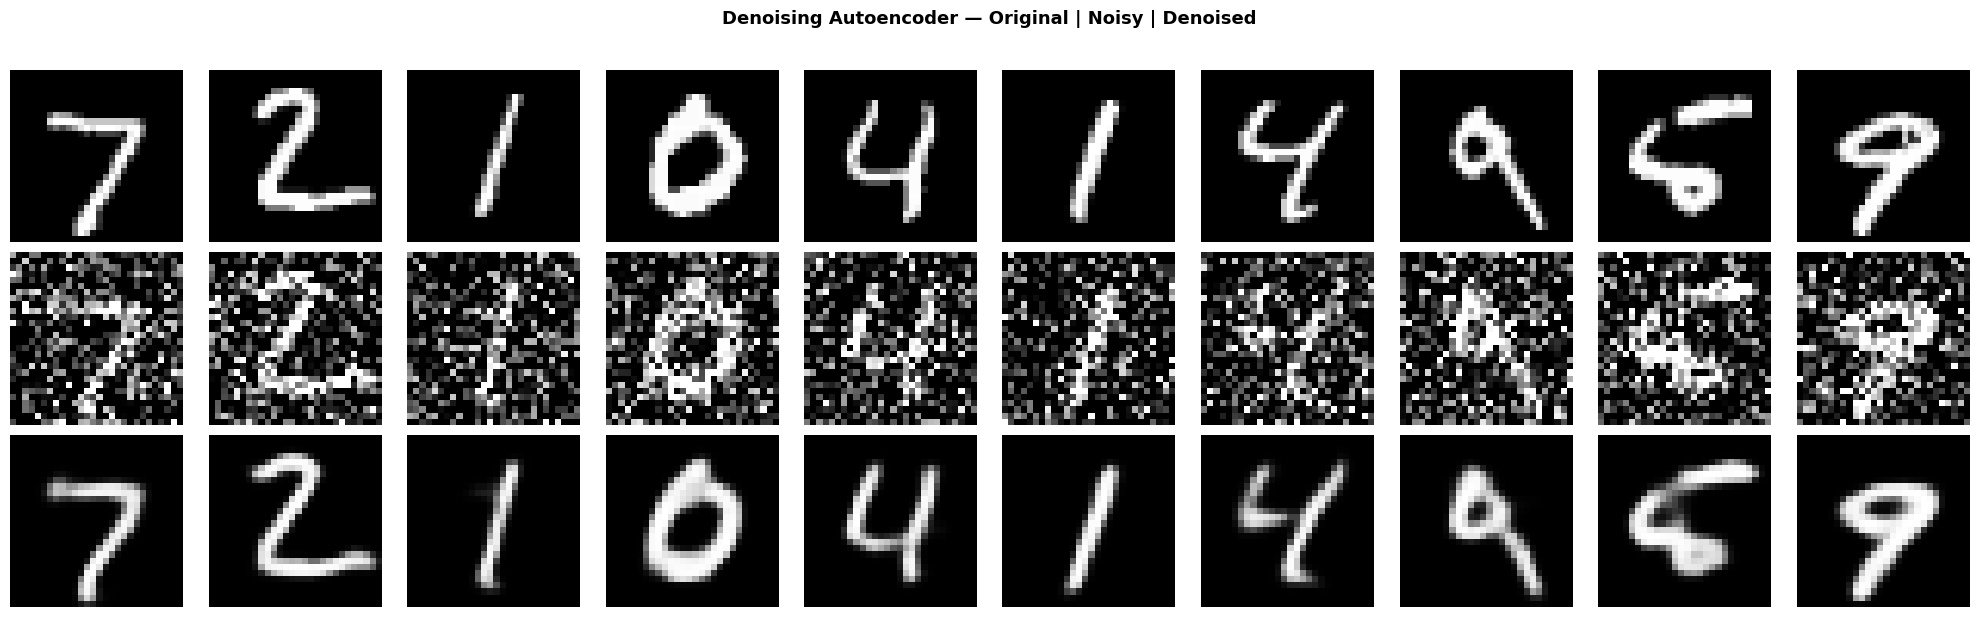

In [ ]:
decoded_denoise = denoise_ae.predict(X_test_noisy, verbose=0)

n = 10
fig, axes = plt.subplots(3, n, figsize=(20, 6))
fig.suptitle("Denoising Autoencoder — Original | Noisy | Denoised",
             fontsize=13, fontweight='bold', y=1.02)
row_labels = ["Original", "Noisy Input", "Denoised Output"]
images_rows = [X_test_2d, X_test_noisy, decoded_denoise]
for row_idx, (label, imgs) in enumerate(zip(row_labels, images_rows)):
    for col_idx in range(n):
        ax = axes[row_idx, col_idx]
        ax.imshow(imgs[col_idx].reshape(28, 28), cmap='gray', interpolation='nearest')
        ax.set_axis_off()
    axes[row_idx, 0].set_ylabel(label, fontsize=11, rotation=90, labelpad=40)
plt.tight_layout()
plt.show()

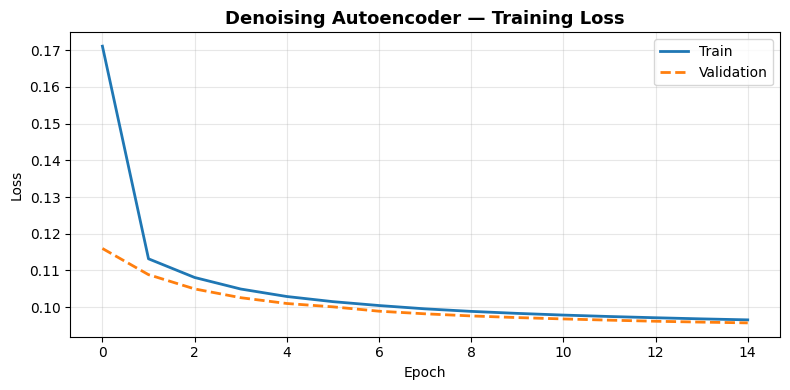

In [ ]:
plot_loss(history_denoise, title="Denoising Autoencoder — Training Loss")

---

## Summary

| Type | Key Idea | Architecture |
|------|----------|-------------|
| **Vanilla** | Basic compression & reconstruction | 784 → 64 → 784 |
| **Multilayer** | Deeper with intermediate layers | 784 → 128 → 64 → 128 → 784 |
| **Convolutional** | Exploits spatial structure of images | Conv+Pool → Conv+Upsample |
| **Sparse** | L1 regularization forces sparse activations | 784 → 32 (L1) → 784 |
| **Denoising** | Learns to recover clean images from noisy input | Conv-based, noisy in → clean out |

Each approach tackles the same core goal — learning a compressed representation — but from a different angle. Depending on your use case (compression, feature learning, noise removal, anomaly detection) one type will fit better than the others.